In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pathlib
import time
from sklearn import ensemble, metrics, preprocessing
from sklearn.experimental import enable_hist_gradient_boosting
import threadpoolctl
from scipy import stats
import joblib

#### Misc options

In [2]:
## Self explanatory
save_plots = True

## Toggle plot titles (off for thesis and papers, generally speaking)
show_titles = False

## Toggle plot grid
show_grid = False

## Black and white?
black_and_white = True

## If true, load existing model (does not train a new one)
load_existing = True
## If true, save the trained model
save_model = False

## If true, evaluate and save feature importances
## Otherwise, load previous results
## Note: currently not implemented
compute_importances = False

#### Parameter options

In [3]:
saved_models = {
    ## BALANCE
    ## Higher overtraining. Slightly better performance in test (fractions of percentage)
    'sachiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.010,
        'max_leaf_nodes' : 200,
        'max_iter' : 5000,
        'soft_threshold': 0.7,
        'hard_threshold': 0.9924
    },
    ## Lower ovetraining. Looks better under K-S test. Slightly worse performance in test (fractions of percentage)
    'shamshel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.7,
        'hard_threshold': 0.985
    },
    ## BKGSKEW
    ## From an overtraining standpoint, this is the better one of the bkgskew
    'ramiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.656
    },
    ## This has quite more overtraining, but loses less signal
    'israfel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.015,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.714
    },
    ## Salvatore's HBDT, for performance comparison.
    ## Somewhat similar to israfel, does not match his original HBDT
    'sandalphon': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.01,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.637
    }
}

In [4]:
## Either one of the names in list(saved_models) or 'temp' for custom new model
model_to_use = 'shamshel'

if model_to_use in saved_models:
    daughter_momenta = saved_models[model_to_use]['daughter_momenta']
    dataset_type = saved_models[model_to_use]['dataset_type']
    training_params = {key: saved_models[model_to_use][key] for key in ['learning_rate', 'max_leaf_nodes', 'max_iter']}
elif model_to_use == 'temp':
    ## Proton and pion momenta
    ## 'VF': use VF momenta
    ## 'DTF': use DTF momenta w/ JPsi m.c.
    ## 'DTFL': use DTF momenta w/ JPsi and Lambda m.c.
    ## 'NO': don't use any momenta for Lambda daughter particles
    daughter_momenta = 'DTF'

    ## Two options:
    ## 'balance': same number of training events for signal and bkg
    ## 'bkgskew' uses 4 mln events of bkg, 500k of signal
    dataset_type = 'bkgskew'

    training_params = {
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 5000
    }
else:
    raise ValueError

# number of threads used by a single job and number of jobs
# the total maximum number of CPU cores used is n_threads x n_jobs
n_threads = 8
n_jobs = 10

In [5]:
if dataset_type not in ['balance', 'bkgskew']:
    raise ValueError

In [6]:
if daughter_momenta == 'VF':
    p_momenta = ['p_PT', 'p_PZ']
    pim_momenta = ['pim_PT', 'pim_PZ']
elif daughter_momenta == 'DTF':
    p_momenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pim_momenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughter_momenta == 'DTFL':
    p_momenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pim_momenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughter_momenta == 'NO':
    p_momenta = []
    pim_momenta = []
else:
    raise ValueError(daughter_momenta + " is not a valid option for momenta usage.")

In [7]:
if dataset_type == 'balance':
    dataset_suffix = 'BAL'
else:
    dataset_suffix = 'SKEW'

classifier_dump_filename = (
    'HBDT_'
    + daughter_momenta
    + '_' + str(training_params['learning_rate'])
    + '_' + str(training_params['max_leaf_nodes'])
    + '_' + str(training_params['max_iter'])
    + '_' + dataset_suffix
)

classifier_dump_filename

'HBDT_DTF_0.003_100_2500_BAL'

In [8]:
## Create plots directory, if missing
repo_dir = str(pathlib.Path.home()) + '/classifier-studies/'

plot_directory = (
    repo_dir + 'plots/'
    + 'HBDT/'
    + 'train_and_evaluate_HBDT/'
    + classifier_dump_filename + '/'
)

state_directory = repo_dir + '20_HBDT/' + 'saved_states/'

pathlib.Path(plot_directory).mkdir(parents=True, exist_ok=True)
pathlib.Path(state_directory).mkdir(parents=True, exist_ok=True)

# Load data

In [9]:
input_dir = repo_dir + '/data/'
input_train = input_dir + 'train_dataset_' +  dataset_type + '.h5'
input_test = input_dir + 'test_dataset_' +  dataset_type + '.h5'

In [10]:
df_train = pd.read_hdf(input_train, 'LHCb_Train')
df_train

,p_PT,p_PZ,DTF_FixJPsi_p_PT,DTF_FixJPsi_p_PZ,DTF_FixJPsiLambda_p_PT,DTF_FixJPsiLambda_p_PZ,pim_PT,pim_PZ,DTF_FixJPsi_pim_PT,DTF_FixJPsi_pim_PZ,...,L_VFASPF_CHI2_VDOF,Lb_VFASPF_CHI2_VDOF,L_BPVIPCHI2,Lb_BPVIPCHI2,L_BPVVDCHI2,Lb_BPVVDCHI2,DTF_FixJPsi_status,DTF_FixJPsiLambda_status,TYPE,DTF_FixJPsiLambda_Lb_M
0,2391.007324,53119.367188,3109.104248,55021.527344,2674.173096,50463.800781,989.212524,9728.215820,395.459991,9636.396484,...,1.999228,2.617834,7.783529,0.275361,9.396670e+02,43.821186,0.0,0.0,1,5642.995117
1,665.045532,33222.363281,858.999207,33044.460938,918.579163,35519.261719,264.080444,4548.199707,58.953770,4661.238281,...,3.834748,0.764857,2.052681,3.653825,1.111560e+04,43.061302,0.0,1.0,1,5725.535645
2,4809.560059,69587.210938,2526.715576,35863.093750,2477.713379,35118.335938,715.287170,8111.864746,718.622498,8492.106445,...,1.598892,4.070712,7.986773,15.390973,1.534330e+05,236.864914,0.0,0.0,1,5649.050781
3,787.348022,13282.785156,1318.262573,21621.804688,1366.567871,22419.171875,181.239487,4025.402100,139.180206,4125.206055,...,0.835794,0.104946,0.137557,1.657936,1.895357e+04,3631.897705,0.0,0.0,1,5532.559570
4,2990.258789,42095.085938,2862.283447,39731.078125,2839.418701,39281.101562,662.368652,9727.785156,620.543213,9689.310547,...,1.805324,0.836892,2.284361,1.377249,3.258634e+06,1370.535400,0.0,0.0,1,5886.123047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145293,805.121277,23507.595703,814.090576,23055.335938,1359.963013,37917.859375,552.082092,24046.093750,506.498505,22791.193359,...,95.045044,1.236983,3.500154,66.592827,8.296238e+06,1136.414185,0.0,1.0,0,4926.012695
145294,653.301514,19669.052734,403.274017,18379.828125,336.683594,16323.865234,360.564453,8928.512695,84.689331,8790.658203,...,1.846003,25.181692,72.114159,22.795586,1.628411e+04,427.659424,0.0,0.0,0,4932.150391
145295,645.209595,13305.105469,432.491089,10379.948242,243.679337,6748.758301,239.370438,3528.149170,305.574707,4204.743652,...,38.324047,24.636105,67.084892,28.038248,3.932625e+06,120.323692,0.0,1.0,0,6270.460449
145296,815.101501,18208.404297,731.964661,16345.332031,2177.278320,49956.578125,120.630455,2712.889404,119.802505,2716.831787,...,0.025877,1.267947,0.395967,13.967916,1.833557e+05,288.725372,0.0,0.0,0,6501.849121


In [11]:
df_test = pd.read_hdf(input_test, 'LHCb_Test')
df_test

,p_PT,p_PZ,DTF_FixJPsi_p_PT,DTF_FixJPsi_p_PZ,DTF_FixJPsiLambda_p_PT,DTF_FixJPsiLambda_p_PZ,pim_PT,pim_PZ,DTF_FixJPsi_pim_PT,DTF_FixJPsi_pim_PZ,...,L_VFASPF_CHI2_VDOF,Lb_VFASPF_CHI2_VDOF,L_BPVIPCHI2,Lb_BPVIPCHI2,L_BPVVDCHI2,Lb_BPVVDCHI2,DTF_FixJPsi_status,DTF_FixJPsiLambda_status,TYPE,DTF_FixJPsiLambda_Lb_M
0,3802.969727,32496.773438,5022.233398,42028.570312,4365.903809,36884.359375,603.782715,3548.854248,384.483734,3575.219238,...,11.445946,1.518785,3.788127,0.116450,2583.435547,487.001343,0.0,1.0,1,5609.720215
1,3309.829102,29165.937500,2514.102539,21862.863281,2672.662109,23123.589844,572.437073,2176.231934,262.199677,2262.454346,...,0.093210,2.236516,1.516899,0.545056,2518.564209,727.137756,0.0,1.0,1,5720.921387
2,3945.632080,42366.277344,3935.839111,42401.468750,3960.475586,42686.105469,274.731293,3882.562012,327.349091,3843.060059,...,0.007283,1.155756,1.756956,6.017722,9607.723633,217.517792,0.0,0.0,1,5518.159180
3,2209.906006,40773.085938,2922.173096,48958.382812,2981.473145,49736.199219,918.814392,9660.885742,617.249268,9534.126953,...,0.687938,1.323909,1.660285,0.015930,5940.551758,418.925354,0.0,0.0,1,5690.572266
4,4713.348633,89298.039062,2544.720459,48355.136719,3891.671143,73182.562500,363.490723,5198.387207,367.125793,5196.061035,...,0.000517,1.014582,2.714195,1.045764,891391.312500,12.841259,0.0,0.0,1,6682.464844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015290,1578.699219,91183.453125,730.855469,50967.277344,527.207825,35936.726562,382.100586,18075.050781,273.884705,18706.072266,...,2.785461,6.188182,9.583981,1069.463135,15049.113281,103207.796875,0.0,0.0,0,4961.707520
4015291,920.719177,26135.546875,1465.078491,42237.433594,1331.812378,38478.769531,64.040855,6124.985352,105.621498,5821.173340,...,0.777651,22.842735,50.954292,46.082180,404028.406250,1169.987427,0.0,0.0,0,6296.701660
4015292,448.241089,22580.591797,534.955505,27879.978516,776.303284,38285.660156,43.548950,6153.875977,71.570152,6166.460938,...,36.631618,6.644543,17.403641,51.600163,229647.156250,580.023499,0.0,0.0,0,4890.033691
4015293,484.433594,33877.257812,570.967163,37443.843750,468.737030,31336.445312,262.678040,15982.551758,248.601746,15788.620117,...,4.101008,2.000728,2.358656,11.211392,174135.875000,102.474869,0.0,1.0,0,4896.677734


# Train the classifier
Or load a previously trained one. Whatever.

In [12]:
fixed_features = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

features = p_momenta + pim_momenta + fixed_features

In [13]:
X_train = df_train.loc[:, features].to_numpy()
Y_train = df_train.loc[:, 'TYPE'].to_numpy()

X_test = df_test.loc[:, features].to_numpy()
Y_test = df_test.loc[:, 'TYPE'].to_numpy()

In [14]:
saved_state_file = state_directory + classifier_dump_filename + '.joblib'

In [15]:
if load_existing:
    HBDT = joblib.load(saved_state_file)
    print(f"HBDT imported.")
else:
    HBDT = ensemble.HistGradientBoostingClassifier(**training_params)
    
    tick = time.perf_counter()
    with threadpoolctl.threadpool_limits(n_threads, user_api="openmp"):
        HBDT.fit(X_train, Y_train)
    tock = time.perf_counter()
    print(f"HBDT trained in {(tock - tick)/60:0.4f} minutes.")
    
    if save_model:
        joblib.dump(HBDT, saved_state_file)
        print(f"HBDT saved.")

HBDT imported.


# Results evaluation

In [16]:
Y_train_predicted = HBDT.predict(X_train)
Y_test_predicted = HBDT.predict(X_test)

In [17]:
## predict_proba returns a NumberOfEvents * NumberOfClasses matrix
## The way we have defined it, the second column is the probability of class 1 (i.e. signal)
## Therefore we get that one
Y_train_proba_predicted = HBDT.predict_proba(X_train)[:,1]
Y_test_proba_predicted = HBDT.predict_proba(X_test)[:,1]

## Confusion matrices

In [18]:
def percentage_confusion_matrix(y_true, y_predicted):
    cmat = metrics.confusion_matrix(y_true, y_predicted)
    
    ## This normalizes to total number of events, signal and background
    #return cmat/np.sum(cmat)
    
    ## This normalizes by row: bkg to bkg, sig to sig
    return preprocessing.normalize(cmat,norm='l1')

In [19]:
def plot_conf_matrix(confusion_matrix, is_test: bool = False) -> None:
    if black_and_white:
        color_string = 'wkkw'
        cmap = 'gray_r'
    else:
        color_string = 'wkkw'
        
        if is_test:
            cmap = 'RdPu'
        else:
            cmap = 'bone_r'
    
    plt.imshow(confusion_matrix, cmap=cmap)
    ax = plt.gca()
    plt.colorbar(label='Fraction of events')
    plt.clim(0,1)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted bkg', 'Predicted signal'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual bkg', 'Actual signal'))
    plt.text(0, 0, "{:.2%}".format(confusion_matrix[0, 0]), ha='center', va='center', color=color_string[0])
    plt.text(0, 1, "{:.2%}".format(confusion_matrix[1, 0]), ha='center', va='center', color=color_string[1])
    plt.text(1, 0, "{:.2%}".format(confusion_matrix[0, 1]), ha='center', va='center', color=color_string[2])
    plt.text(1, 1, "{:.2%}".format(confusion_matrix[1, 1]), ha='center', va='center', color=color_string[3])
    
    if show_titles:
        if is_test:
            plt.title("Predicted vs. actual classes (test set)")
        else:
            plt.title("Predicted vs. actual classes (training set)")
            
    if save_plots:
        if is_test:
            plt.savefig(plot_directory + 'confmatrix_test' + '.pdf', bbox_inches='tight')
        else:
            plt.savefig(plot_directory + 'confmatrix_train' + '.pdf', bbox_inches='tight')
    
    plt.show()

In [20]:
confusion_matrix_train = percentage_confusion_matrix(Y_train, Y_train_predicted)
confusion_matrix_test = percentage_confusion_matrix(Y_test, Y_test_predicted)

Just to be clear, normalization is on *actual* events.

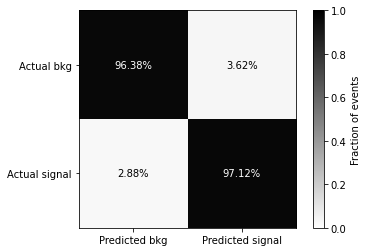

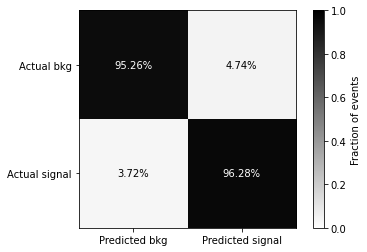

In [21]:
plot_conf_matrix(confusion_matrix_train, is_test=False)
plot_conf_matrix(confusion_matrix_test, is_test=True)

## Classification reports

In [22]:
print("TRAIN")
print(metrics.classification_report(Y_train, Y_train_predicted))
print(f'The average precision score on training data is: {metrics.average_precision_score(Y_train, Y_train_proba_predicted):.4f}')
print("------------------------------------------------------")
print("TEST")
print(metrics.classification_report(Y_test, Y_test_predicted))
print(f'The average precision score on test data is: {metrics.average_precision_score(Y_test, Y_test_proba_predicted):.4f}')

TRAIN
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     72649
           1       0.96      0.97      0.97     72649

    accuracy                           0.97    145298
   macro avg       0.97      0.97      0.97    145298
weighted avg       0.97      0.97      0.97    145298

The average precision score on training data is: 0.9953
------------------------------------------------------
TEST
              precision    recall  f1-score   support

           0       1.00      0.95      0.98   4007222
           1       0.04      0.96      0.08      8073

    accuracy                           0.95   4015295
   macro avg       0.52      0.96      0.53   4015295
weighted avg       1.00      0.95      0.97   4015295

The average precision score on test data is: 0.4301


## ROC curve

In [23]:
train_false_positives, train_true_positives, train_roc_thresholds = metrics.roc_curve(Y_train, Y_train_proba_predicted)
train_auc = metrics.roc_auc_score(Y_train, Y_train_proba_predicted)

test_false_positives, test_true_positives, test_roc_thresholds = metrics.roc_curve(Y_test, Y_test_proba_predicted)
test_auc = metrics.roc_auc_score(Y_test, Y_test_proba_predicted)

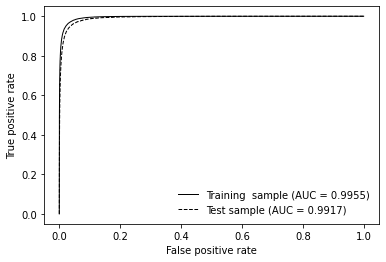

In [24]:
if not black_and_white:
    train_color = 'tab:red'
    test_color = 'tab:blue'
    linewidth=1.5
else:
    train_color = 'black'
    test_color='black'
    linewidth=1

plt.plot(train_false_positives,
         train_true_positives,
         label=f'Training  sample (AUC = {train_auc:.4f})',
         color=train_color,
         linestyle='-',
         linewidth=linewidth
)
plt.plot(test_false_positives,
         test_true_positives,
         label=f'Test sample (AUC = {test_auc:.4f})',
         color=test_color,
         linestyle='--',
         linewidth=linewidth
)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

if show_grid:
    plt.grid()

plt.legend(frameon=False)

if show_titles:
    plt.title("HBDT receiver operating characteristic")

if save_plots:
    plt.savefig(plot_directory + 'roc' + '.pdf', bbox_inches='tight')
    
plt.show()

## Precision-recall curve

In [25]:
train_precision, train_recalls, train_prc_thresholds = metrics.precision_recall_curve(Y_train, Y_train_proba_predicted)
test_precision, test_recalls, test_prc_thresholds = metrics.precision_recall_curve(Y_test, Y_test_proba_predicted)

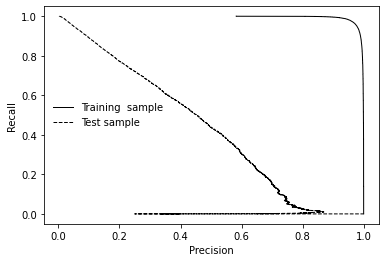

In [26]:
if not black_and_white:
    train_color = 'tab:red'
    test_color = 'tab:blue'
    linewidth=1.5
else:
    train_color = 'black'
    test_color='black'
    linewidth=1

plt.plot(train_precision,
         train_recalls,
         label=f'Training  sample',
         color=train_color,
         linestyle='-',
         linewidth=linewidth
)
plt.plot(test_precision,
         test_recalls,
         label=f'Test sample',
         color=test_color,
         linestyle='--',
         linewidth=linewidth
)

plt.xlabel('Precision')
plt.ylabel('Recall')

if show_grid:
    plt.grid()

plt.legend(frameon=False)
if show_titles:
    plt.title("HBDT precision-recall curve")

if save_plots:
    plt.savefig(plot_directory + 'prec_recall' + '.pdf', bbox_inches='tight')

plt.show()

## Response distribution

In [27]:
df_train_model_response = pd.DataFrame({'predicted' : Y_train_proba_predicted, 'class' : Y_train, 'dataset': 'train'})
df_test_model_response = pd.DataFrame({'predicted' : Y_test_proba_predicted, 'class' : Y_test, 'dataset': 'test'})

df_model_response = pd.concat([df_train_model_response, df_test_model_response], ignore_index=True)

del(df_train_model_response)
del(df_test_model_response)

In [28]:
is_training = df_model_response['dataset'] == 'train'
is_test = df_model_response['dataset'] == 'test'
is_signal = df_model_response['class'] == 1
is_bkg = df_model_response['class'] == 0

In [29]:
def plot_compared_responses(
    label_1,
    label_2,
    title,
    common_selection,
    selection_1,
    selection_2,
    filename,
    cumulative = False,
    legend_frame = False,
    legend_loc = None
):
    
    if black_and_white:
        hist_1_colorpars = {
            'histtype': 'stepfilled',
            'edgecolor': 'black',
            'hatch': '--',
            'facecolor': 'none',#mcolors.to_rgba('dimgrey', alpha=.05),
        }
        
        hist_2_colorpars = {
            'histtype': 'stepfilled',
            'edgecolor': 'black',
            'hatch': '//',
            'facecolor': 'none',#mcolors.to_rgba('gainsboro', alpha=.05),
        }
    else:
        hist_1_colorpars = {
            'histtype': 'stepfilled',
            'edgecolor': 'royalblue',
            'color': mcolors.to_rgba('lightblue', alpha=0.2),
        }
        
        hist_2_colorpars = {
            'histtype': 'stepfilled',
            'edgecolor': 'tab:orange',
            'color': mcolors.to_rgba('navajowhite', alpha=0.2),
        }        

    plt.hist(
        df_model_response.loc[common_selection & selection_1, 'predicted'],
        label=label_1,
        bins=100,
        range=(0,1),
        density=True,
        cumulative=cumulative,
        **hist_1_colorpars
    )

    plt.hist(
        df_model_response.loc[common_selection & selection_2, 'predicted'],
        label=label_2,
        bins=100,
        range=(0,1),
        density=True,
        cumulative=cumulative,
        **hist_2_colorpars
    )

    if not cumulative:
        plt.yscale('log')
    
    if legend_loc is not None:
        plt.legend(loc=legend_loc, frameon=legend_frame)
    else:
        plt.legend(loc='best', frameon=legend_frame)
    
    if show_titles:
        plt.title(title)
    plt.ylabel("Probability density")
    plt.xlabel("HBDT response")
    
    if save_plots:
        plt.savefig(plot_directory + filename + '.pdf', bbox_inches='tight')
    
    plt.show()

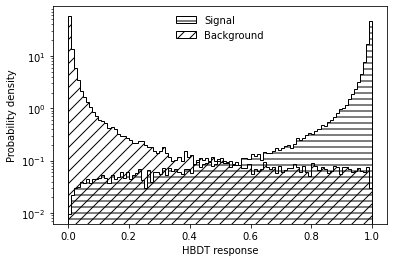

In [30]:
plot_compared_responses(
    label_1='Signal',
    label_2='Background',
    title='Training dataset',
    common_selection=is_training,
    selection_1=is_signal,
    selection_2=is_bkg,
    filename='sig_vs_bkg_train',
    legend_loc='upper center'
)

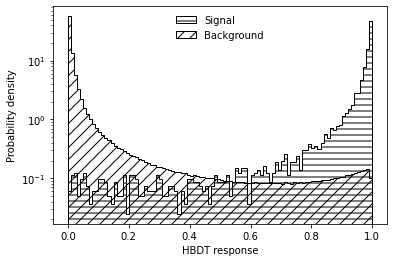

In [31]:
plot_compared_responses(
    label_1='Signal',
    label_2='Background',
    title='Test dataset',
    common_selection=is_test,
    selection_1=is_signal,
    selection_2=is_bkg,
    filename='sig_vs_bkg_test',
    legend_loc = 'upper center'
)

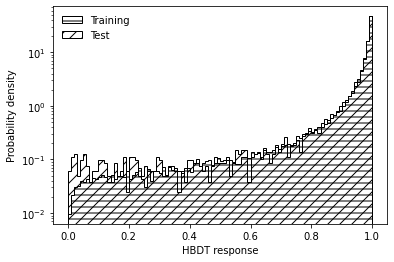

In [32]:
plot_compared_responses(
    label_1='Training',
    label_2='Test',
    title='Signal',
    common_selection=is_signal,
    selection_1=is_training,
    selection_2=is_test,
    filename='sig_train_vs_test',
    legend_loc = 'upper left'
)

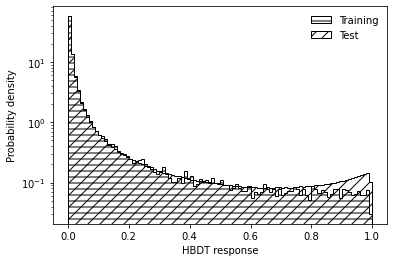

In [33]:
plot_compared_responses(
    label_1='Training',
    label_2='Test',
    title='Background',
    common_selection=is_bkg,
    selection_1=is_training,
    selection_2=is_test,
    filename='bkg_train_vs_test',
)

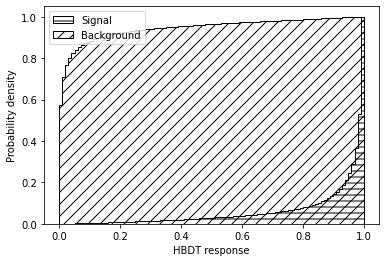

In [34]:
plot_compared_responses(
    label_1='Signal',
    label_2='Background',
    title='Training dataset',
    common_selection=is_training,
    selection_1=is_signal,
    selection_2=is_bkg,
    filename='cumulative_train',
    cumulative=True,
    legend_frame=True,
    legend_loc='upper left'
)

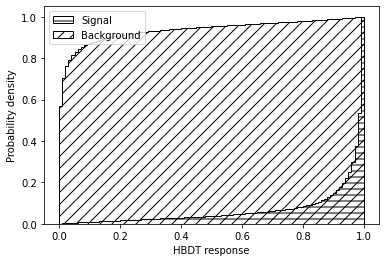

In [35]:
plot_compared_responses(
    label_1='Signal',
    label_2='Background',
    title='Test dataset',
    common_selection=is_test,
    selection_1=is_signal,
    selection_2=is_bkg,
    filename='cumulative_test',
    cumulative=True,
    legend_frame=True,
    legend_loc='upper left'
)

## Kolmogorov-Smirnov test
### Signal (train vs. test)

In [36]:
stats.kstest(
    df_model_response.loc[is_training & is_signal, 'predicted'],
    df_model_response.loc[is_test & is_signal, 'predicted'],
)

KstestResult(statistic=0.011351830314597688, pvalue=0.30403142410880346)

### Background (train vs. test)

In [37]:
stats.kstest(
    df_model_response.loc[is_training & is_bkg, 'predicted'],
    df_model_response.loc[is_test & is_bkg, 'predicted'],
)

KstestResult(statistic=0.011966509781322299, pvalue=2.643631566700883e-09)